In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [5]:
cfg_default = dict(
    seed=0, save_dir=None,

    bs=512, grid_size=64, rollout_steps=4096, n_steps_clip=32,
    start=0, end=262144,
)

seed = 0
cfgs = []
for i in range(8):
    cfg = cfg_default.copy()
    cfg.update(seed=seed, start=i*32768, end=(i+1)*32768)
    cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/gol_0/{seed}_{i}")
    cfgs.append(cfg)

# print(cfgs)
print(len(cfgs))

8


In [6]:
commands = experiment_utils.create_commands(cfgs, prefix='python train_game_of_life.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python train_game_of_life.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/gol_0/0_0" --bs=512 --grid_size=64 --rollout_steps=4096 --n_steps_clip=32 --start=0      --end=32768 
python train_game_of_life.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/gol_0/0_1" --bs=512 --grid_size=64 --rollout_steps=4096 --n_steps_clip=32 --start=32768  --end=65536 
python train_game_of_life.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/gol_0/0_2" --bs=512 --grid_size=64 --rollout_steps=4096 --n_steps_clip=32 --start=65536  --end=98304  
...
8 commands


# Visualize Results

In [7]:
import jax
import jax.numpy as jnp

In [61]:
data = []
all_params = []
for cfg in cfgs:
    save_dir = cfg['save_dir']
    print(save_dir)
    data.append(util.load_pkl(save_dir, "data"))
    all_params.append(util.load_pkl(save_dir, "all_params"))

/home/akarshkumar0101/nca-alife-data/gol_0/0_0
/home/akarshkumar0101/nca-alife-data/gol_0/0_1
/home/akarshkumar0101/nca-alife-data/gol_0/0_2
/home/akarshkumar0101/nca-alife-data/gol_0/0_3
/home/akarshkumar0101/nca-alife-data/gol_0/0_4
/home/akarshkumar0101/nca-alife-data/gol_0/0_5
/home/akarshkumar0101/nca-alife-data/gol_0/0_6
/home/akarshkumar0101/nca-alife-data/gol_0/0_7


In [62]:
data = jax.tree.map(lambda *x: np.concatenate(x, axis=0), *data)
all_params = jax.tree.map(lambda *x: np.concatenate(x, axis=0), *all_params)

In [81]:
gol = 6152
all_params[gol]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0], dtype=int32)

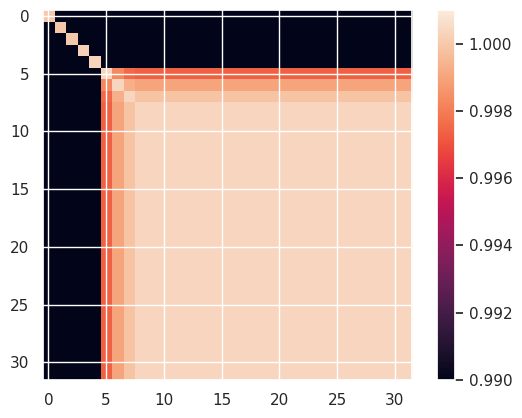

In [118]:
a = data['scores'][246756]
plt.imshow(a, vmin=0.99, vmax=1.001)
plt.colorbar()

(0.95, 1.005)

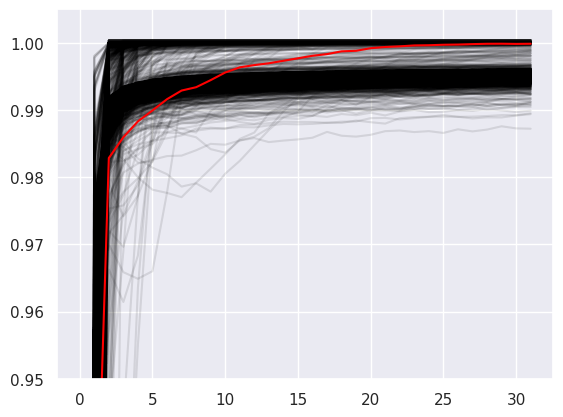

In [88]:
plt.plot(data['similarities'][::50].T, c='black', alpha=0.1);
plt.plot(data['similarities'][gol], c='red');
plt.ylim(0.95, 1.005)
# plt.xlim(0, 5)

In [173]:
oe = data['similarities'][:, 1:].mean(axis=-1)
oe.shape

(262144,)

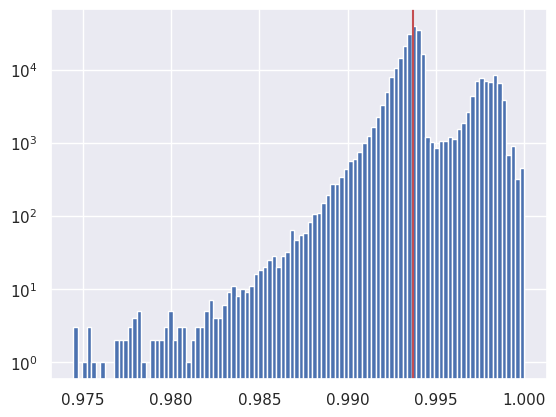

In [174]:
plt.hist(oe, bins=100);
plt.axvline(oe[gol], c='r')
plt.yscale('log')

In [175]:
(oe[gol]>oe).sum()/len(oe)

0.4320716857910156

In [176]:
oe.argmin()

7803

In [183]:
def conv2d_3x3_sum(x):
    x_padded = jnp.pad(x, pad_width=1, mode='wrap')
    kernel = jnp.ones((3, 3))
    return jax.lax.conv_general_dilated(
            x_padded[None, None, :, :],  # Add batch and channel dimensions
            kernel[None, None, :, :],  # Add input and output channel dimensions
            window_strides=(1, 1),
            padding='VALID',
            dimension_numbers=('NCHW', 'OIHW', 'NCHW'))[0, 0]
def step_ca(state, _, params):
    state_f = state.astype(float)
    n_neighbors = conv2d_3x3_sum(state_f) - state_f
    update_idx = state_f * 9 + n_neighbors
    next_state = params[update_idx.astype(int)]
    return next_state, state
rng = jax.random.PRNGKey(0)
sparsity = jnp.linspace(.05, .4, num=4)
state_init = jax.random.uniform(rng, shape=(4, 64, 64), minval=0, maxval=1)
state_init = jnp.floor(state_init+sparsity[:, None, None]).astype(int)

def unroll_ca(state_init, params, n_steps=4096):
    state_final, state_vid = jax.lax.scan(partial(step_ca, params=params), state_init, None, length=n_steps)
    return state_vid

def show_ca(x, show=False):
    params = jnp.array(all_params[x])
    state_vid = jax.vmap(partial(unroll_ca, params=params))(state_init)
    img = rearrange(state_vid[::state_vid.shape[0]//4, ::state_vid.shape[1]//8, :, :], "R C H W -> (R H) (C W)", R=4)
    vid = rearrange(state_vid, "(R C) T H W -> T (R H) (C W)", R=2)
    img = repeat(img, "... -> ... 3").astype(np.uint8)*255
    vid = repeat(vid, "... -> ... 3").astype(np.uint8)*255
    if show:
        plt.figure(figsize=(20, 20))
        plt.imshow(img)
        plt.grid(False)
        plt.show()
    return vid, img


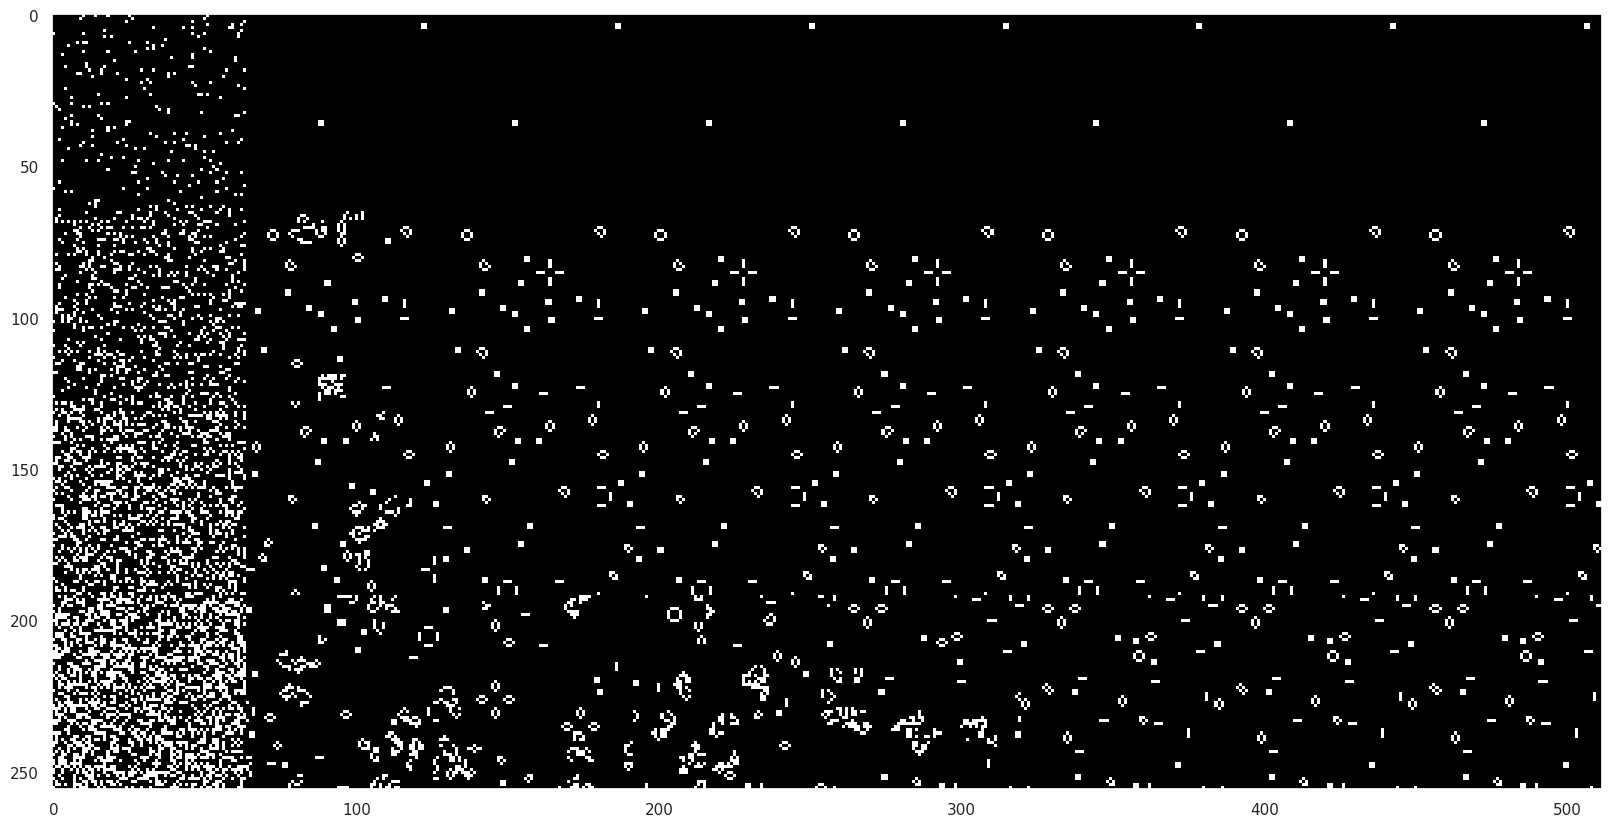

((4096, 128, 128, 3), (256, 512, 3))

In [188]:
vid, img = show_ca(gol, show=True)
vid.shape, img.shape

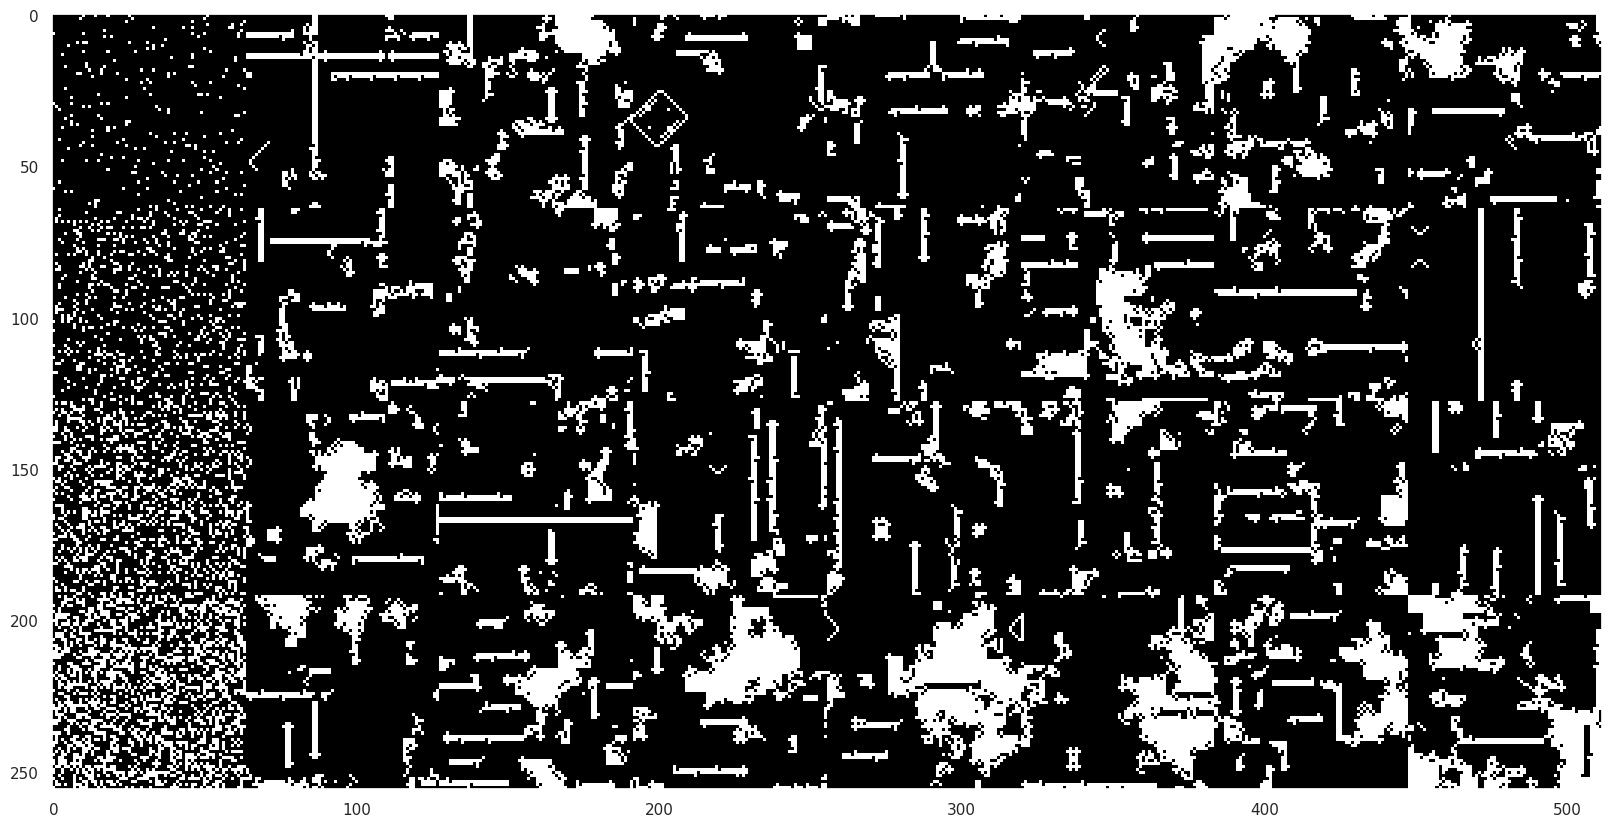

((4096, 128, 128, 3), (256, 512, 3))

In [189]:
vid, img = show_ca(7803, show=True)
vid.shape, img.shape


In [197]:
for i, p in enumerate(tqdm(oe.argsort()[:20])):
    vid, img = show_ca(p)
    print(vid.shape)
    imageio.mimwrite(f'./temp/gol_{i}_{p}.gif', np.array(vid)[:2048:2], fps=30)

  0%|          | 0/20 [00:00<?, ?it/s]

(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)


In [204]:
vid, img = show_ca(gol)
imageio.mimwrite(f'./temp/gol__{gol}.gif', np.array(vid)[:2048:2], fps=30)

In [205]:
gol

6152

In [172]:
import imageio
imageio.mimwrite(f'./temp/gol.gif', np.array(vid)[::2], fps=20)

In [201]:
oe.argsort()[:20]

array([  7803,   7291, 133519,  34591,  14782,  34335,  33823,  55871,
        55615,   2067,   2579,  47999,   3731,   3219,  35615,  15411,
        55903,  36703,   8059,  53007])

In [200]:
all_params[7803].reshape(2, 9)

array([[1, 1, 0, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=int32)

In [8]:
from clip_jax import MyFlaxCLIP
resize_fn = partial(jax.image.resize, shape=(224, 224), method='nearest')
clip_model = MyFlaxCLIP()

/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-08-10 05:22:58.269481: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [11]:
def conv2d_3x3_sum(x):
    x_padded = jnp.pad(x, pad_width=1, mode='wrap')
    kernel = jnp.ones((3, 3))
    return jax.lax.conv_general_dilated(
            x_padded[None, None, :, :],  # Add batch and channel dimensions
            kernel[None, None, :, :],  # Add input and output channel dimensions
            window_strides=(1, 1),
            padding='VALID',
            dimension_numbers=('NCHW', 'OIHW', 'NCHW'))[0, 0]

def step_ca(state, _, params):
    state_f = state.astype(float)
    n_neighbors = conv2d_3x3_sum(state_f) - state_f
    update_idx = state_f * 9 + n_neighbors
    next_state = params[update_idx.astype(int)]
    return next_state, None

def unroll_ca(state_init, params):
    def chunk_step(state_init, _):
        state, _ = jax.lax.scan(partial(step_ca, params=params), state_init, None, length=64)
        return state, state_init
    _, state_vid = jax.lax.scan(chunk_step, state_init, None, length=32)
    return state_vid

params_gol = jnp.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
x_gol_glider = jnp.zeros((32, 32), dtype=int)
x_gol_glider = x_gol_glider.at[:3, :3].set(jnp.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]]))

bs = 256
rng = jax.random.PRNGKey(0)
sparsity = jnp.linspace(.4, .4, num=bs)
state_init = jax.random.uniform(rng, shape=(bs, 64, 64), minval=0, maxval=1)
state_init = jnp.floor(state_init+sparsity[:, None, None]).astype(int)

# @jax.jit
def eval_clip_complexity(params):
    state_vid = jax.vmap(partial(unroll_ca, params=params))(state_init) # B T H W
    print('state_vid ', state_vid.shape)
    vid_clip = jax.vmap(jax.vmap(resize_fn))(state_vid.astype(jnp.float32))
    vid_clip = repeat(vid_clip, "... -> ... 3")
    print('clip vid ', vid_clip.shape)
    z_img = jax.vmap(jax.vmap(clip_model.embed_img))(vid_clip)
    scores = (z_img@z_img.mT)
    print('scores ', scores.shape)
    scores_tril = jax.vmap(partial(jnp.tril, k=-1))(scores)
    similarities = (scores_tril).max(axis=-1)
    return dict(state_vid=state_vid, z_img=z_img, scores=scores, similarities=similarities)

In [10]:
data0 = eval_clip_complexity(params_gol)

state_vid  (256, 32, 64, 64)
clip vid  (256, 32, 224, 224, 3)


2024-08-10 05:23:14.647134: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[8192,768,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[8192,3,224,224]{3,2,1,0}, f32[768,3,32,32]{3,2,1,0}), window={size=32x32 stride=32x32}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-08-10 05:23:25.220619: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 11.573585712s
Trying algorithm eng0{} for conv (f32[8192,768,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[8192,3,224,224]{3,2,1,0}, f32[768,3,32,32]{3,2,1,0}), window={size=32x32 stride=32x32}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queu

scores  (256, 32, 32)


In [12]:
data1 = eval_clip_complexity(params_gol)

state_vid  (256, 32, 64, 64)
clip vid  (256, 32, 224, 224, 3)
scores  (256, 32, 32)


(0.98, 1.0)

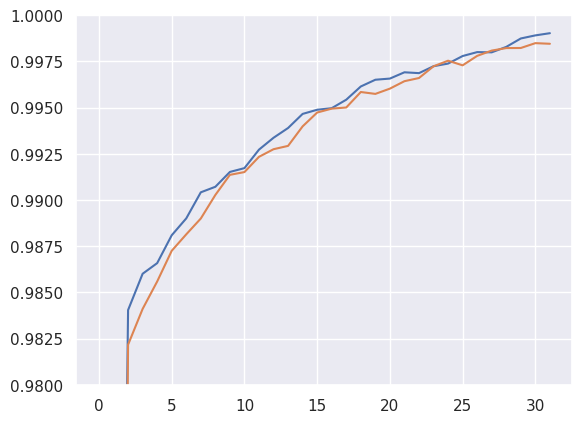

In [17]:
plt.plot(data0['similarities'].mean(axis=0))
plt.plot(data1['similarities'].mean(axis=0))
plt.ylim(0.98, 1.0)